In [78]:
import pandas as pd
import numpy as np
import re

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import spacy
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 300
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## 1- Sentiment analysis of french and US tweets per vaccine:

In [3]:
# merging files
tweets_fr = pd.concat(
    map(pd.read_csv, ['../data/tweets_fr_week_2_translated.csv', '../data/tweets_fr_week4_translated.csv']), ignore_index=True)
tweets_fr.shape

(12558, 8)

In [4]:
#drop duplicates (6)
tweets_fr = tweets_fr.drop_duplicates()

In [5]:
tweets_us_north = pd.read_csv('../data/tweets_us_north.csv')
tweets_us_south = pd.read_csv('../data/tweets_us_south.csv')

### 1- Perform sentiment analysis classification by using pretrained model “distilbert-base-uncased-finetuned-sst-2-english” (default classifier from 🤗):

In [6]:
classifier = pipeline('sentiment-analysis')

In [7]:
tweets_fr["sen_ana"] = tweets_fr["translated_text"].apply(classifier)

In [8]:
tweets_us_north["sen_ana"] = tweets_us_north["text"].apply(classifier)
tweets_us_south["sen_ana"] = tweets_us_south["text"].apply(classifier)

### 2-Split result into two columns:

In [9]:
def split_label(lb):
    label = re.findall(r"[A-Z]+", lb)[0]
    return label

In [10]:
def split_score(sc):
    score = re.findall(r"\d+\.\d+", sc)[0]
    return score   

In [12]:
tweets_fr["score"] = tweets_fr["sen_ana"].apply(str).apply(split_score)
tweets_fr["label"] = tweets_fr["sen_ana"].apply(str).apply(split_label)

In [13]:
tweets_us_north["score"] = tweets_us_north["sen_ana"].apply(str).apply(split_score)
tweets_us_north["label"] = tweets_us_north["sen_ana"].apply(str).apply(split_label)

In [14]:
tweets_us_south["score"] = tweets_us_south["sen_ana"].apply(str).apply(split_score)
tweets_us_south["label"] = tweets_us_south["sen_ana"].apply(str).apply(split_label)

In [18]:
# Change column score from object to float
tweets_fr['score'] = tweets_fr['score'].astype('float64')
tweets_us_north['score'] = tweets_us_north['score'].astype('float64')
tweets_us_south['score'] = tweets_us_south['score'].astype('float64')

**Save files:**

In [20]:
tweets_fr.to_csv('../data/tweet_fr_sa.csv', index=False)
tweets_us_north.to_csv('../data/tweets_us_north_sa.csv', index=False)
tweets_us_south.to_csv('../data/tweets_us_south_sa.csv', index=False)

### 3- Bar plots:

In [28]:
tweets_fr_gp = tweets_fr.groupby(["vaccine", "label"])["score"].mean().reset_index()

In [56]:
fig = px.bar(tweets_fr_gp, x='vaccine', y='score', color ='label', barmode='group',title= 'Sentiments analysis of French tweets toward COVID-19 vaccines',
            labels={
                 "score": "Score",
                 "vaccine": "",
                 "label": "Sentiment"
             },
            color_discrete_map={ # replaces default color mapping by value
                "NEGATIVE": "#9467bd", "POSITIVE": "lightsalmon"
            },
                        category_orders={"vaccine": ["pfizer", "moderna","astrazeneca", "johnson"]
                        },
             template="simple_white"
            )
fig.update_yaxes(showgrid=True, showline=False, tickwidth=0, tickcolor='white')
fig.update_xaxes(showline=True, zeroline=True)
            
fig.show()

In [46]:
tweets_us_north_gp = tweets_us_north.groupby(["vaccine", "label"])["score"].mean().reset_index()

In [53]:
fig = px.bar(tweets_us_north_gp, x='vaccine', y='score', color ='label', barmode='group',title= 'Sentiments analysis of Northern US tweets toward COVID-19 vaccines',
            labels={
                 "score": "Score",
                 "vaccine": "",
                 "label": "Sentiment"
             },
            color_discrete_map={ # replaces default color mapping by value
                "NEGATIVE": "#9467bd", "POSITIVE": "lightsalmon"
            },
                        category_orders={"vaccine": ["pfizer", "moderna","astrazeneca", "johnson"]
                        },
             template="simple_white"
            )
fig.update_yaxes(showgrid=True, showline=False, tickwidth=0, tickcolor='white')
fig.update_xaxes(showline=True, zeroline=True)
            
fig.show()

In [48]:
tweets_us_south_gp = tweets_us_south.groupby(["vaccine", "label"])["score"].mean().reset_index()

In [52]:
fig = px.bar(tweets_us_south_gp, x='vaccine', y='score', color ='label', barmode='group',title= 'Sentiments analysis of Southern US tweets toward COVID-19 vaccines',
            labels={
                 "score": "Score",
                 "vaccine": "",
                 "label": "Sentiment"
             },
            color_discrete_map={ # replaces default color mapping by value
                "NEGATIVE": "#9467bd", "POSITIVE": "lightsalmon"
            },
                        category_orders={"vaccine": ["pfizer", "moderna","astrazeneca", "johnson"]
                        },
             template="simple_white"
            )
fig.update_yaxes(showgrid=True, showline=False, tickwidth=0, tickcolor='white')
fig.update_xaxes(showline=True, zeroline=True)
            
fig.show()

## 2- Word frequency:

In [58]:
custom_stopwords = STOPWORDS.union(set(['pfizer', 'astrazeneca', 'moderna', 'johnson', 'janssen']))

In [71]:
def word_frequency(df):
    word_vectorizer = TfidfVectorizer(
        ngram_range=(1,3),
        analyzer='word',
        stop_words=custom_stopwords
    )
    
    # Remove short words, pumctuation, numbers and special characters
    sparse_matrix = word_vectorizer.fit_transform(
        df["translated_text"].apply(
            lambda x: " ".join(
                [w for w in x.split() if len(w)>3])
            ),
        df["translated_text"].str.replace("[^a-zA-Z#]", " ")
        )
        
    
    # Create frequency matrix
    frequencies = sparse_matrix.sum(axis=0)
    
    # Create DF from frequency matrix
    result_df = pd.DataFrame(frequencies.reshape(-1,1), index=word_vectorizer.get_feature_names(), columns=['frequency'])
    
    # Return sorted DF
    return result_df    

In [66]:
tweets_fr_janssen = tweets_fr[tweets_fr["vaccine"] == 'johnson']

In [67]:
tweets_fr_janssen.head(1)

,id,date,location,follower_count,retweets,text,vaccine,translated_text,sen_ana,score,label
667,1395070529724370944,2021-05-19 17:35:08,"Paris, France",714,0,"En live du meetup #dataprivacy --&gt; la #pseudonymisation nécessite des actions différentes par rapport à l'anonymisation selon Valérie Gabay, Senior Manager Data Privacy chez Johnson &amp; Johnson",johnson,"Live meeting #dataprivacy --&gt; #pseudonymization requires different actions compared to anonymization according to Valérie Gabay, Senior Manager Data Privacy at Johnson &amp; Johnson","[{'label': 'NEGATIVE', 'score': 0.9929102659225464}]",0.99291,NEGATIVE


In [72]:
freq_tweets_fr_janssen = word_frequency(tweets_fr_janssen)

/Users/armelleleguelte/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning:

The default value of regex will change from True to False in a future version.



In [74]:
freq_tweets_fr_janssen = freq_tweets_fr_janssen.reset_index()

In [75]:
freq_tweets_fr_janssen = freq_tweets_fr_janssen.rename(columns={'index':'words'})

In [76]:
tuples_nol = [tuple(x) for x in freq_tweets_fr_janssen.values]

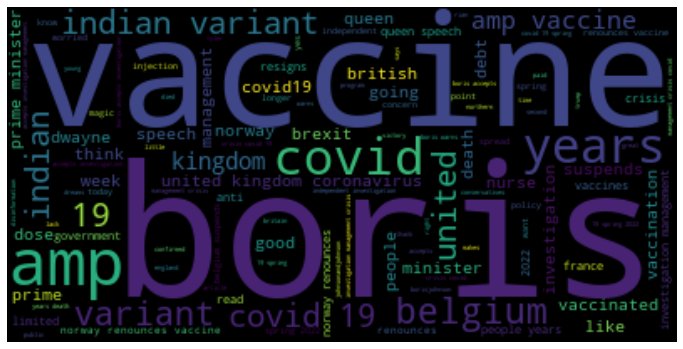

In [79]:
plt.figure(figsize= (12, 8))
wordcloud = WordCloud().generate_from_frequencies(dict(tuples_nol))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()